### Dating App A/B test
Механика приложения следующая: пользователи видят в приложении анкеты друг друга и могут ставить друг другу лайки или дизлайки. Если пользователи поставили друг другу лайк – это называется мэтч, и у пользователей появляется возможность познакомиться.

Команда приложения разработала новый алгоритм для поиска наиболее подходящих анкет. Для проверки работы алгоритма был проведен АБ-тест. Все пользователи были разделены на две группы. Пользователи в группе с номером 0 пользовались приложением со старым алгоритмом. Все пользователи в группе 1 пользовались приложением с новым алгоритмом для поиска анкет.

Задача – оценить, правда ли, что новый алгоритм улучшил качество сервиса.

In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as ss
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

In [2]:
df = pd.read_csv('dating_data.csv')

Будем считать, что метрика, отражающая качество сервиса - среднее количество мэтчей на пользователя. Так как в колонках user_id_1 и
user_id_2 представлены одни и те же юзеры с айди от 1 до 1000, то среднее можно оценить по одной колонке - user_id_1

Сформулируем нулевую гипотезу - новая механика не влияет на метрику, альтернативная гипотеза, соответственно, что новая механика на неё влияет.

In [73]:
# Сначала посмотрим на разницу, не используя статистический критерий. Кажется, что новая механика даёт значительно больше мэтчей
print(df.query('group == 1').is_match.sum() / df.query('group == 1').group.count())
print(df.query('group == 0').is_match.sum() / df.query('group == 0').group.count())

0.40207776177741206
0.19490818030050083


In [72]:
df_1 = df.groupby(['user_id_1', 'group'], as_index=False)['is_match']\
         .sum()\
         .rename(columns={'is_match': 'matches_count'})

Если взглянуть на распределения по группам, то видно, что группа 1 (с новой механикой) имеет более высокое среднее количество мэтчей и нормальное распределение. В группе со старой механикой большая часть пользователей имеют 1-2 мэтча.

<Axes: xlabel='matches_count', ylabel='Count'>

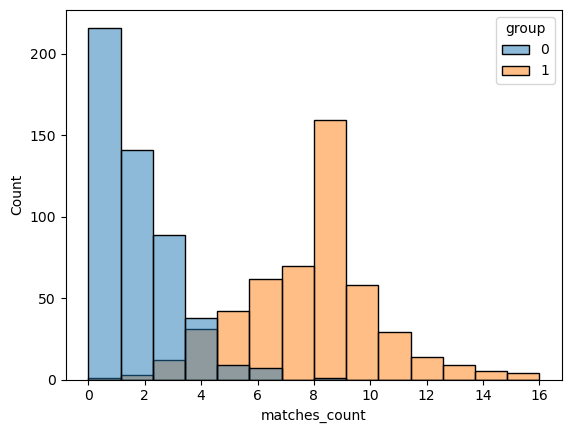

In [5]:
sns.histplot(data=df_1, x='matches_count', hue='group')

Проведем анализ методом линейной регрессии, сравним 2 категориальные переменные:

In [6]:
df_1 = df_1.assign(average_matches_count=1)
X = df_1[['group', 'average_matches_count']]
Y = df_1['matches_count']
estimator = OLS(Y, X).fit()
print(estimator.summary())

                            OLS Regression Results                            
Dep. Variable:          matches_count   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     2226.
Date:                Sun, 07 Jan 2024   Prob (F-statistic):          2.29e-256
Time:                        20:52:21   Log-Likelihood:                -2111.3
No. Observations:                1000   AIC:                             4227.
Df Residuals:                     998   BIC:                             4236.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
group                     5.96

Согласно полученным результатам, с применением новой механики есть статистически значимое увеличение целевой метрики (количество мэтчей на пользователя). Дополнительно проведем анализ среднего значения методом Bootstrap

In [7]:
df_1.matches_count = df_1.matches_count.astype('float')
df_1.matches_count.isna().sum()

0

In [70]:
ss.bootstrap((df_1.query('group == 1').matches_count, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=7.617234468937876, high=8.048096192384769), bootstrap_distribution=array([7.8496994 , 7.74348697, 7.79559118, ..., 7.8496994 , 7.94589178,
       7.82164329]), standard_error=0.10991030224902813)

In [9]:
ss.bootstrap((df_1.query('group == 0').matches_count, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=1.746506986027944, high=1.9860279441117765), bootstrap_distribution=array([1.93812375, 1.84031936, 1.91417166, ..., 1.89820359, 1.84431138,
       1.90219561]), standard_error=0.0609753925305885)

Видим, что среднее значение целевой метрики (среднее количество мэтчей на юзера) при применении новой механики имеет доверительный интервал с нижней границей 7.609, что значительно выше верхней границы доверительного интервала метрики

Теперь взглянем на еще одну метрику и выясним, выросло ли <b>общее число активностей</b> на пользователя:

In [57]:
df_2 = df.groupby(['user_id_1', 'group'], as_index=False)['is_match'].count().rename(columns={'is_match': 'total_activity_count'})

Взглянем на распределение, видим, что оно близко к нормальному:

<Axes: xlabel='total_activity_count', ylabel='Count'>

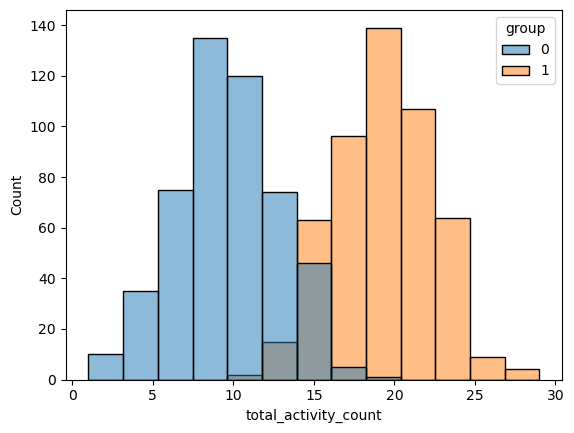

In [39]:
sns.histplot(data=df_2, x='total_activity_count', hue='group')

Взглянем на среднее количество активностей на пользователя:

In [67]:
print(df_2.query('group==0').total_activity_count.mean(), '- количество активновностей на юзера в 0 группе (контроль)')
print(df_2.query('group==1').total_activity_count.mean(), '- количество активновностей на юзера в 1 группе (тест)')

9.564870259481038 - количество активновностей на юзера в 0 группе (контроль)
19.482965931863728 - количество активновностей на юзера в 1 группе (тест)


На первый взгляд оно значительно различается
Для проверки этого утверждения применим t-тест (выборки довольно большие, так что небольшое отхождение от нормальности не сильно важно, учитвая отсутствие больших выбросов):

Для начала критерим Левена проверим гомогенность дисперсий:

In [60]:
ss.levene(df_2.query('group==0').total_activity_count, df_2.query('group==1').total_activity_count)

LeveneResult(statistic=0.4804538582845789, pvalue=0.48837808141783545)

И проведем сам тест

In [62]:
ss.ttest_ind(df_2.query('group==0').total_activity_count, df_2.query('group==1').total_activity_count)

Ttest_indResult(statistic=-51.85383774946492, pvalue=1.8942877064043142e-285)

### Вывод: рост среднего количества мэтчей на юзера статистически значим, следовательно качество сервиса выросло, целесообразно выкатить изменения на всю аудиторию. Кроме того, выросло и общее количество взаимодействий, что явно показало более высокую вовлеченность пользователей